# Laboratorium 6 - rekomendacje grafowe

## Przygotowanie

 * pobierz i wypakuj dataset `movies_graph.zip`
   * dane źródłowe: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data
   * więcej o przekształceniach i filtrowaniu możesz poczytać w notebooku `movies_graph_data_preparation.ipynb`
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab6`
 * zainstaluj potrzebne biblioteki:
 `pip install pykeen torch tqdm seaborn`

## Część 1. - przygotowanie danych

In [1]:
from ast import literal_eval
import csv
import numpy as np
from typing import List, Dict, Tuple
from random import shuffle

import tqdm as notebook_tqdm
import torch
import matplotlib.pyplot as plt
from pykeen.models import ERModel, TransE, TransR, TransH
from pykeen.pipeline import pipeline
from pykeen.predict import predict_target
from pykeen.triples import TriplesFactory

In [2]:
PATH = 'movies_graph'
TRAIN_DATA_RATIO = 0.9

In [3]:
# dataclasses

class Movie:
    def __init__(self,
                 movie_id: str,
                 title: str,
                 genres: List[str], 
                 production_countries: List[str], 
                 collection_name: str,
                 release_year: str):
        self.movie_id = movie_id
        self.title = title
        self.genres = genres
        self.production_countries = production_countries
        self.collection_name = collection_name
        self.release_year = release_year
    
    def add_cast(self,
                 actors: List[str],
                 directors: List[str],
                 screenwriters: List[str],
                 music_composers: List[str]):
        self.actors = actors
        self.directors = directors
        self.screenwriters = screenwriters
        self.music_composers = music_composers
    
    def basic_info(self):
        return {
            'movie_id': self.movie_id,
            'title': self.title,
            'genres': self.genres,
            'production_countries': self.production_countries
        }

    def __str__(self):
        return str(vars(self))
    
    def __repr__(self):
        return self.__str__()


class Review:
    def __init__(self, user_id: str, movie_id: str, rating: str):
        self.user_id = user_id
        self.movie_id = movie_id
        self.rating = float(rating)
    
    def __str__(self):
        return str(vars(self))
    
    def __repr__(self):
        return self.__str__()

In [4]:
# wczytujemy oceny filmow
with open('movies_graph/reviews.csv') as f:
    reader = csv.reader(f)
    header = next(reader)
    ratings = []
    for entry in list(reader):
        user_id, movie_id, rating = entry
        ratings.append(Review(f'u_{user_id}', f'm_{movie_id}', rating))

# podzial na zbior treningowy i testowy
shuffle(ratings)
train_ratings = ratings[:int(len(ratings)*TRAIN_DATA_RATIO)]
test_ratings = ratings[len(train_ratings):]
train_ratings

[{'user_id': 'u_358', 'movie_id': 'm_529', 'rating': 5.0},
 {'user_id': 'u_624', 'movie_id': 'm_180', 'rating': 3.0},
 {'user_id': 'u_481', 'movie_id': 'm_1354', 'rating': 4.0},
 {'user_id': 'u_257', 'movie_id': 'm_52885', 'rating': 4.0},
 {'user_id': 'u_580', 'movie_id': 'm_2100', 'rating': 3.0},
 {'user_id': 'u_150', 'movie_id': 'm_1617', 'rating': 3.0},
 {'user_id': 'u_627', 'movie_id': 'm_339', 'rating': 2.0},
 {'user_id': 'u_308', 'movie_id': 'm_410', 'rating': 3.0},
 {'user_id': 'u_213', 'movie_id': 'm_6281', 'rating': 3.0},
 {'user_id': 'u_472', 'movie_id': 'm_3551', 'rating': 5.0},
 {'user_id': 'u_619', 'movie_id': 'm_410', 'rating': 2.0},
 {'user_id': 'u_442', 'movie_id': 'm_2144', 'rating': 4.0},
 {'user_id': 'u_358', 'movie_id': 'm_1042', 'rating': 4.0},
 {'user_id': 'u_313', 'movie_id': 'm_253', 'rating': 4.0},
 {'user_id': 'u_472', 'movie_id': 'm_246', 'rating': 5.0},
 {'user_id': 'u_299', 'movie_id': 'm_2021', 'rating': 2.0},
 {'user_id': 'u_518', 'movie_id': 'm_2421', 'r

In [5]:
# wczytujemy metadane filmow
def parse_movie_metadata(entry: List[str]):
    movie_id, title, genres, production_countries, collection_name, release_year = entry
    return Movie(f'm_{movie_id}', title, literal_eval(genres), literal_eval(production_countries), collection_name, release_year)

def add_cast_to_movie(movie: Movie, entry: List[str]):
    _movie_id, actors, directors, screenwriters, music_composers = entry
    movie.add_cast(literal_eval(actors), literal_eval(directors), literal_eval(screenwriters), literal_eval(music_composers))

with open('movies_graph/metadata.csv') as f:
    reader = csv.reader(f)
    header = next(reader)
    movies = {f'm_{entry[0]}': parse_movie_metadata(entry) for entry in reader}

with open('movies_graph/credits.csv') as f:
    reader = csv.reader(f)
    header = next(reader)
    for entry in reader:
        movie_id = f'm_{entry[0]}'
        add_cast_to_movie(movies[movie_id], entry)

movies

{'m_949': {'movie_id': 'm_949', 'title': 'Heat', 'genres': ['Action', 'Crime', 'Drama', 'Thriller'], 'production_countries': ['US'], 'collection_name': '', 'release_year': '1995', 'actors': ['Al Pacino', 'Robert De Niro', 'Val Kilmer', 'Jon Voight', 'Tom Sizemore', 'Diane Venora', 'Amy Brenneman', 'Ashley Judd', 'Mykelti Williamson', 'Natalie Portman', 'Ted Levine', 'Tom Noonan', 'Tone Loc', 'Hank Azaria', 'Wes Studi', 'Dennis Haysbert', 'Danny Trejo', 'Henry Rollins', 'William Fichtner', 'Kevin Gage', 'Susan Traylor', 'Jerry Trimble', 'Ricky Harris', 'Jeremy Piven', 'Xander Berkeley', 'Begonya Plaza', 'Rick Avery', 'Hazelle Goodman', 'Ray Buktenica', 'Max Daniels', 'Vince Deadrick Jr.', 'Steven Ford', 'Farrah Forke', 'Patricia Healy', 'Paul Herman', 'Cindy Katz', 'Brian Libby', 'Dan Martin', 'Mario Roberts', 'Thomas Rosales, Jr.', 'Yvonne Zima', 'Mick Gould', 'Bud Cort', 'Viviane Vives', 'Kim Staunton', 'Martin Ferrero', 'Brad Baldridge', 'Andrew Camuccio', 'Kenny Endoso', 'Kimberly F

## Część 2. - zbudowanie zbioru relacji

In [6]:
# generujemy dane dla modelu w formacie (head, relation, tail)
# na start mozesz uzyc malego podzbioru relacji, np. tylko 'positive_rating'

all_relation_types = [
    'positive_rating',
    'neutral_rating',
    'negative_rating',
    'genre',
    'production_country',
    'in_collection',
    'release_year',
    'actor_in',
    'director_of',
    'screenwriter_of',
    'composer_of'
]
basic_relation_types = [
    'positive_rating',
    'negative_rating'
]

def generate_triples(reviews: List[Review], movies: Dict[str, Movie], relation_types: List[str]) -> List[Tuple[str, str, str]]:
    # przetlumacz dane o filmach i recenzjach do formy trojek (head, relation, tail)
    # np. (user_id, 'positive_rating', movie_id)
    # zwroc liste trzyelementowych krotek

    triples = []

    for review in reviews:
        user_id = review.user_id
        rating = review.rating
        movie_id = review.movie_id

        if rating > 2:
            triples.append((user_id, relation_types[0], movie_id))
        else:
            triples.append((user_id, relation_types[1], movie_id))

    return triples

triples = generate_triples(train_ratings, movies, basic_relation_types) # Orginalnie było ratings ale na zajęciach powiedział, że lepiej train_raitings
tf = TriplesFactory.from_labeled_triples(np.array(triples))

## Część 3. - trening modelu

In [7]:
def train_model(triples: List[Tuple[str, str, str]], tf: TriplesFactory):
    # tworzymy obiekt pomocniczy do reprezentacji zbioru danych
    training, testing, validation = tf.split([.8, .1, .1])

    # fix dla niektorych makow
    # mps_device = torch.device("mps")

    # zasadnicza czesc treningu
    pipeline_result = pipeline(
        # device=mps_device, 
        training=training,
        testing=testing,
        validation=validation,
        model=TransE, # to najszybszy i najprostszy, ale i najslabszy model
        epochs=30 # to tylko przykladowa wartosc, na podstawie loss plot ocenimy, czy wystarczy ||| Dopiero koło 30 epoki zaczyna się zbiegać, można se zmienić, albo dać wykres loss_function
    )
    return pipeline_result

pipeline_result = train_model(triples, tf)

using automatically assigned random_state=1419898348
No random seed is specified. Setting to 1066680149.
No cuda devices were available. The model runs on CPU


Training epochs on cpu:   0%|          | 0/30 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/7.23k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.90s seconds


<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

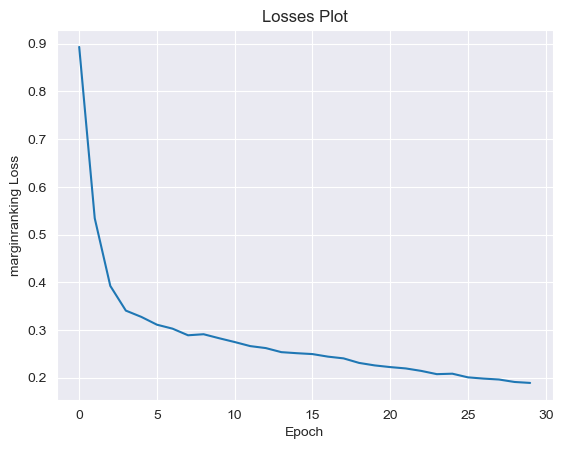

In [8]:
# wykres loss function
pipeline_result.plot_losses()

## Część 4. - rekomendacje

In [9]:
# funkcje pomocnicze
def print_movies(movie_ids: List[str], movies: Dict[str, Movie], print_missing=True):
    for m_id in movie_ids:
        if m_id in movies:
            print(movies[m_id].basic_info())
        elif print_missing:
            print(f'movie_id: {m_id}')

def describe_user(user_id: str, reviews: List[Review], movies: Dict[str, Movie]):
    positive_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating >= 4.0]
    negative_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating <= 2.0]
    neutral_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating > 2.0 and x.rating < 4.0]
    
    print(f'user_id: {user_id}')
    print('Positive ratings:')
    print_movies(positive_ratings, movies, print_missing=False)
    print('Neutral ratings:')
    print_movies(neutral_ratings, movies, print_missing=False)
    print('Negative ratings:')
    print_movies(negative_ratings, movies, print_missing=False)

In [10]:
# Taile czyli to co model uważa że użytkownik oceni pozytywnie
# Można też robić predykcje negatywnych ocen
def recommend(user_id: str, model: ERModel, triples_factory: TriplesFactory, k: int) -> List[str]:
    relation = 'positive_rating'
    prediction = predict_target(model=model, head=user_id, relation=relation, triples_factory=triples_factory)
    
    prediction_df = prediction.df

    sorted_predictions = prediction_df.sort_values(by='score', ascending=False)
    top_k_movies = sorted_predictions['tail_label'].head(k).tolist()

    return top_k_movies

In [11]:
# user_id = 'u_547' # uzytkownik z bardzo duza historia
user_id = 'u_244'
describe_user(user_id, ratings, movies)

user_id: u_244
Positive ratings:
{'movie_id': 'm_1374', 'title': 'Rocky IV', 'genres': ['Drama'], 'production_countries': ['US']}
{'movie_id': 'm_3489', 'title': '88 Minutes', 'genres': ['Crime', 'Mystery', 'Thriller'], 'production_countries': ['US']}
{'movie_id': 'm_54503', 'title': 'Shuang ma lian huan', 'genres': ['Action', 'Foreign'], 'production_countries': ['HK', 'TW']}
{'movie_id': 'm_2028', 'title': 'Say Anything...', 'genres': ['Comedy', 'Drama', 'Romance'], 'production_countries': ['US']}
{'movie_id': 'm_41569', 'title': 'The Nomi Song', 'genres': ['Documentary', 'Foreign'], 'production_countries': ['DE']}
{'movie_id': 'm_527', 'title': 'Once Were Warriors', 'genres': ['Drama'], 'production_countries': ['NZ']}
{'movie_id': 'm_54001', 'title': 'مسافر', 'genres': ['Drama'], 'production_countries': ['IR']}
{'movie_id': 'm_58559', 'title': 'Confession of a Child of the Century', 'genres': ['Drama'], 'production_countries': ['FR', 'DE', 'GB']}
{'movie_id': 'm_1376', 'title': 'Swee

In [12]:
recommendation = recommend(user_id, pipeline_result.model, tf, 20)
print('Recommendation:')
print_movies(recommendation, movies)

Recommendation:
{'movie_id': 'm_1721', 'title': '...Più forte ragazzi!', 'genres': ['Adventure', 'Action', 'Comedy'], 'production_countries': ['IT']}
{'movie_id': 'm_1073', 'title': 'Arlington Road', 'genres': ['Drama', 'Thriller', 'Mystery'], 'production_countries': ['US']}
movie_id: m_589
{'movie_id': 'm_2762', 'title': 'Young and Innocent', 'genres': ['Drama', 'Crime'], 'production_countries': ['GB']}
movie_id: m_356
{'movie_id': 'm_1580', 'title': 'Rope', 'genres': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'production_countries': ['US']}
{'movie_id': 'm_364', 'title': 'Batman Returns', 'genres': ['Action', 'Fantasy'], 'production_countries': ['GB', 'US']}
movie_id: m_50
{'movie_id': 'm_1393', 'title': 'Die Höhle des gelben Hundes', 'genres': ['Documentary', 'Drama'], 'production_countries': ['MN', 'DE']}
{'movie_id': 'm_593', 'title': 'Солярис', 'genres': ['Drama', 'Science Fiction', 'Adventure', 'Mystery'], 'production_countries': ['RU']}
{'movie_id': 'm_587', 'title': 'Big Fish'

## Część 5. - metryki

In [13]:
# HitRatio@k - iterujemy po testowym zbiorze ocen, odsiewamy tylko oceny pozytywne,
# generujemy rekomendacje dlugosci k dla uzytkownika i sprawdzamy, czy oceniony film znalazl sie w rekomendacji
# zwracamy stosunek liczby trafien do liczby wszystkich prob

# wersja nieco bardziej zaawansowana - zamiast rekomendacji wyciagamy z modelu predykcje konkretnej relacji
# i liczymy skutecznosc w przewidywaniu, czy ocena byla pozytywna, negatywna czy neutralna

def hit_ratio(test_ratings: List[Review], model: ERModel, tf: TriplesFactory, k: int, recommend: callable) -> float:
    
    hit = 0
    attemps = 0

    for review in test_ratings:
        user_id = review.user_id
        movie_id = review.movie_id
        rating = review.rating
        if rating > 2:
            recommendation = recommend(user_id, model, tf, k)
            if movie_id in recommendation:
                hit += 1
            attemps += 1

    return hit/attemps if attemps > 0 else 0


hit_ratio(test_ratings, pipeline_result.model, tf, 50, recommend)

0.12270574304322084

In [14]:
# AvgPosition@k - iterujemy po testowym zbiorze ocen, odsiewamy tylko oceny pozytywne, (tu tylko oceny pozytywne zostawiamy)
# generujemy rekomendacje dlugosci k dla uzytkownika i sprawdzamy, czy oceniony film znalazl sie w rekomendacji
# jesli tak, zapisujemy pozycje, na ktorej zarekomendowano film
# zwracamy srednia pozycje, na ktorych wystepowaly filmy

def avg_position(test_ratings: List[Review], model: ERModel, tf: TriplesFactory, k: int, recommend: callable) -> float:
    
    position = 0
    attemps = 0

    for review in test_ratings:
        user_id = review.user_id
        movie_id = review.movie_id
        rating = review.rating
        if rating > 2:
            recommendation = recommend(user_id, model, tf, k)
            if movie_id in recommendation:
                position += recommendation.index(movie_id) + 1
            attemps += 1

    return position/attemps if attemps > 0 else -1

avg_position(test_ratings, pipeline_result.model, tf, 50, recommend)

2.9618117229129663

## Część 5. - porównanie modeli

Wytrenowaliśmy podstawowy model, umiemy wygenerować rekomendacje i ocenić jakość modelu. Teraz przeanalizujemy, jakie zmiany mogą pozytywnie wpłynąć na jakość rekomendacji.

Porównaj bazowy model (np. TransH wytrenowany tylko na relacjach `positive_rating` i `negative_rating`) z dwoma innymi podejściami. Wybierz dwie spośród poniszych modyfikacji lub zaproponuj własną:
1. Zmiana modelu - zamiast TransH możesz użyć np. TransR albo RESCAL
2. Dodanie większej liczby typów relacji - możesz dodać oceny neutralne, metadane filmu, informacje o obsadzie. Nawet jeśli jakaś relacja nie jest wykorzystywana w procesie rekomendacji, może poprawić jakość wytrenowanego modelu. Zwróć uwagę, by jako rekoemndację zwracać wyłącznie identyfikatory filmów, nie innych wierzchołków.
3. Zmiana sposobu rekomendacji - obecny tryb opiera się na przewidywaniu relacji `positive_rating`. Możesz poprawić ten proces przez np. odsiewanie tych kandydatów, którzy występują także w predykcji relacji `negative_rating` czy filtrowanie kandydatów po metadanych (np. gatunku).

Porównanie trzech modeli oprzyj na dwóch zdefiniowanych w Części 4. metrykach dla wybranej wartości `k`.

In [15]:
# 2 z 3 powyższych wybieramy
# 2. mamy też inne rekomendacje no, aktorów czy coś bo mamy tylko narazie positive, negative z all_relation_types
# Można też negatywne przewidzieć, gdzieś tam wyżej pisałem. Jakieś k małe rzędu 10, 20 bo trwa to dość długo

# Zamiana modelu na TransR
def train_model_R(triples: List[Tuple[str, str, str]], tf: TriplesFactory):
    # tworzymy obiekt pomocniczy do reprezentacji zbioru danych
    training, testing, validation = tf.split([.8, .1, .1])


    pipeline_result = pipeline(
        training=training,
        testing=testing,
        validation=validation,
        model=TransR, 
        epochs=30
    )
    return pipeline_result

pipeline_result_R = train_model(triples, tf)


INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [55384, 7226, 7226]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/30 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/7.23k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.89s seconds


<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

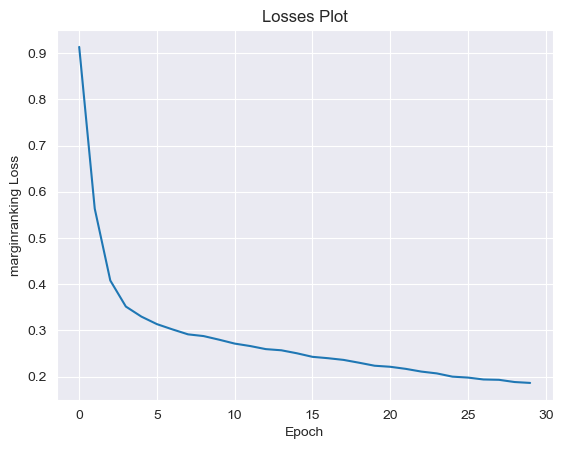

In [16]:
pipeline_result_R.plot_losses()

In [17]:
def train_model_H(triples: List[Tuple[str, str, str]], tf: TriplesFactory):
    # tworzymy obiekt pomocniczy do reprezentacji zbioru danych
    training, testing, validation = tf.split([.8, .1, .1])


    pipeline_result = pipeline(
        training=training,
        testing=testing,
        validation=validation,
        model=TransH, 
        epochs=30
    )
    return pipeline_result

pipeline_result_H = train_model(triples, tf)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [55384, 7226, 7226]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/30 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/226 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/7.23k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.87s seconds


<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

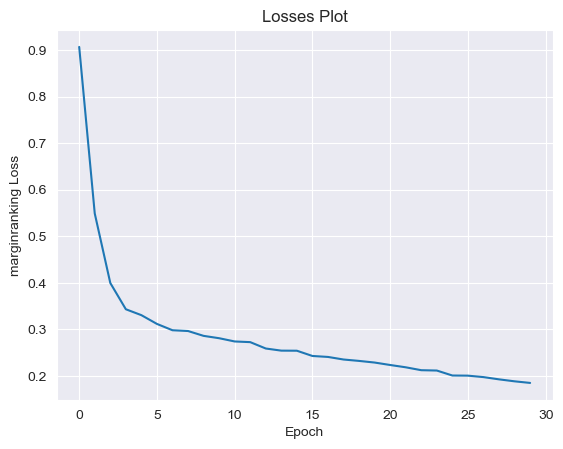

In [18]:
pipeline_result_H.plot_losses()

In [19]:
hit_E_1 = hit_ratio(test_ratings, pipeline_result.model, tf, 50, recommend)
hit_R_1 = hit_ratio(test_ratings, pipeline_result_R.model, tf, 50, recommend)
hit_H_1 = hit_ratio(test_ratings, pipeline_result_H.model, tf, 50, recommend)

avg_E_1 = avg_position(test_ratings, pipeline_result.model, tf, 50, recommend)
avg_R_1 = avg_position(test_ratings, pipeline_result_R.model, tf, 50, recommend)
avg_H_1 = avg_position(test_ratings, pipeline_result_H.model, tf, 50, recommend)

In [20]:
def show_differences(models, hit_values, avg_values):  

    x = np.arange(len(models))
    width = 0.6

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

    bars_hit = axes[0].bar(x, hit_values, color='skyblue', width=width)
    axes[0].set_title('Hit Ratio@50')
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('Hit Ratio')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models)

    for bar in bars_hit:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    bars_avg  = axes[1].bar(x, avg_values, color='lightcoral', width=width)
    axes[1].set_title('Average Position@50')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Average Position')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(models)

    for bar in bars_avg:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

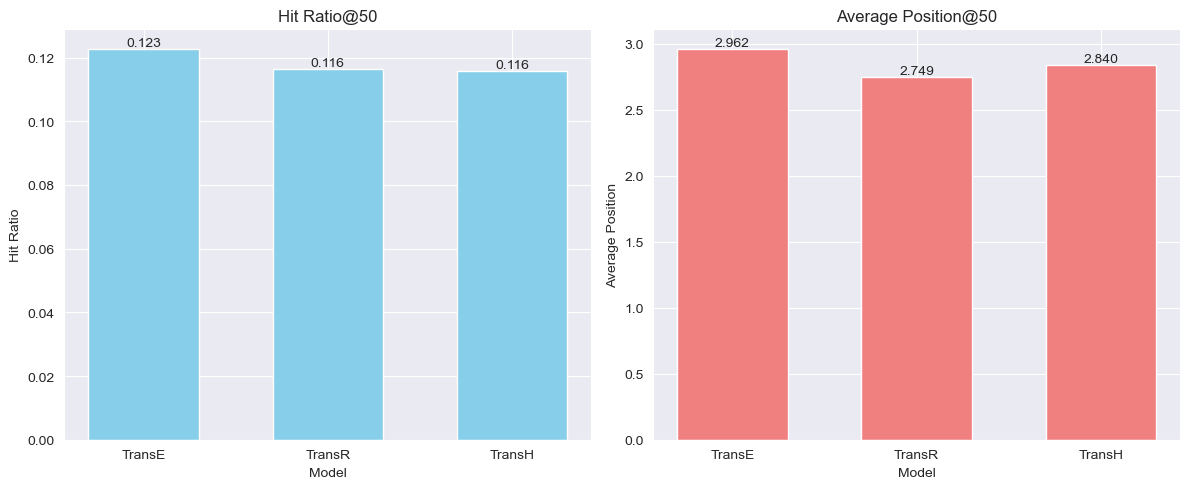

In [21]:
models = ['TransE', 'TransR', 'TransH']
hit_values_1 = [hit_E_1 , hit_R_1, hit_H_1]  
avg_values_1 = [avg_E_1, avg_R_1, avg_H_1]

show_differences(models, hit_values_1, avg_values_1)

In [22]:
# 3. Zmiana sposobu rekomendacji


# Rekomendujemy co najwyżej k filmów, które są w w top_k rekomendacjach i nie ma ich w top_k najbardziej nielubianych
def recommend_most_liked(user_id: str, model: ERModel, triples_factory: TriplesFactory, k: int) -> List[str]:
    positive_relation = 'positive_rating'
    positive_prediction = predict_target(model=model, head=user_id, relation=positive_relation, triples_factory=triples_factory)

    prediction_df = positive_prediction.df
    sorted_predictions = prediction_df.sort_values(by='score', ascending=False)
    top_movies = sorted_predictions['tail_label'].head(k).tolist()

    negative_relation = 'negative_rating'
    negative_prediction = predict_target(model=model, head=user_id, relation=negative_relation, triples_factory=triples_factory)

    negative_prediction_df = negative_prediction.df
    negative_movies = negative_prediction_df.sort_values(by='score', ascending=False)
    most_hated_movies = set(negative_movies['tail_label'].head(k).tolist())

    filtered_movies = [movie_id for movie_id in top_movies if movie_id not in most_hated_movies]

    return filtered_movies

In [23]:
hit_E_2 = hit_ratio(test_ratings, pipeline_result.model, tf, 50, recommend_most_liked)
hit_R_2 = hit_ratio(test_ratings, pipeline_result_R.model, tf, 50, recommend_most_liked)
hit_H_2 = hit_ratio(test_ratings, pipeline_result_H.model, tf, 50, recommend_most_liked)

avg_E_2 = avg_position(test_ratings, pipeline_result.model, tf, 50, recommend_most_liked)
avg_R_2 = avg_position(test_ratings, pipeline_result_R.model, tf, 50, recommend_most_liked)
avg_H_2 = avg_position(test_ratings, pipeline_result_H.model, tf, 50, recommend_most_liked)

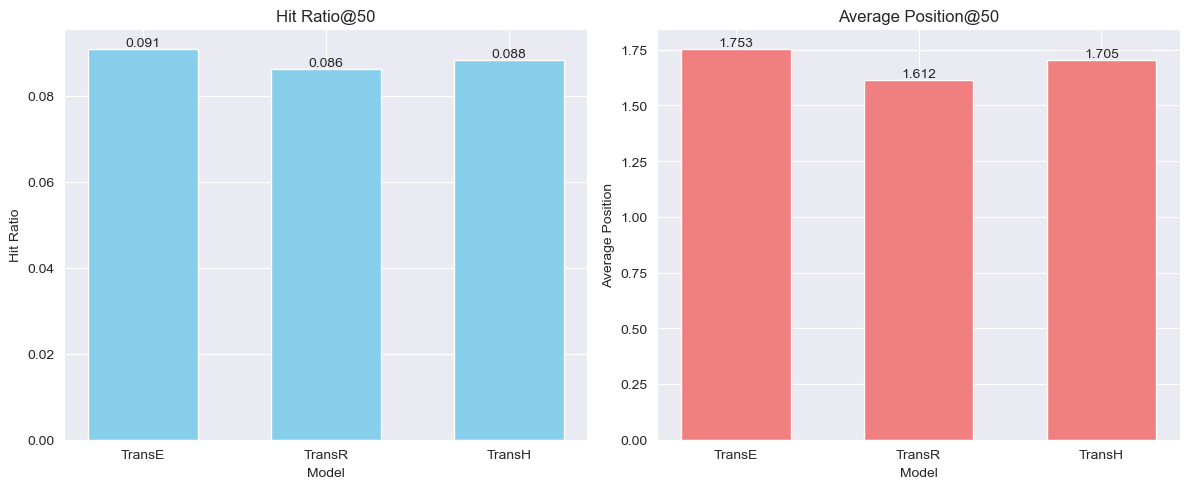

In [24]:
models_2 = ['TransE', 'TransR', 'TransH']
hit_values_2 = [hit_E_2 , hit_R_2, hit_H_2]  
avg_values_2 = [avg_E_2, avg_R_2, avg_H_2]

show_differences(models_2, hit_values_2, avg_values_2)

In [25]:
# Rekomendujemy k filmów, które są w w top_k rekomendacjach i nie ma ich w top_k najbardziej nielubianych
def recommend_k_most_liked(user_id: str, model: ERModel, triples_factory: TriplesFactory, k: int) -> List[str]:
    positive_relation = 'positive_rating'
    positive_prediction = predict_target(model=model, head=user_id, relation=positive_relation, triples_factory=triples_factory)

    prediction_df = positive_prediction.df
    sorted_predictions = prediction_df.sort_values(by='score', ascending=False)
    top_movies = sorted_predictions['tail_label'].tolist()

    negative_relation = 'negative_rating'
    negative_prediction = predict_target(model=model, head=user_id, relation=negative_relation, triples_factory=triples_factory)

    negative_prediction_df = negative_prediction.df
    negative_movies = negative_prediction_df.sort_values(by='score', ascending=False)
    most_hated_movies = set(negative_movies['tail_label'].head(k).tolist())

    filtered_movies = [movie_id for movie_id in top_movies if movie_id not in most_hated_movies]

    return filtered_movies[:k]

In [26]:
hit_E_3 = hit_ratio(test_ratings, pipeline_result.model, tf, 50, recommend_k_most_liked)
hit_R_3 = hit_ratio(test_ratings, pipeline_result_R.model, tf, 50, recommend_k_most_liked)
hit_H_3 = hit_ratio(test_ratings, pipeline_result_H.model, tf, 50, recommend_k_most_liked)

avg_E_3 = avg_position(test_ratings, pipeline_result.model, tf, 50, recommend_k_most_liked)
avg_R_3 = avg_position(test_ratings, pipeline_result_R.model, tf, 50, recommend_k_most_liked)
avg_H_3 = avg_position(test_ratings, pipeline_result_H.model, tf, 50, recommend_k_most_liked)

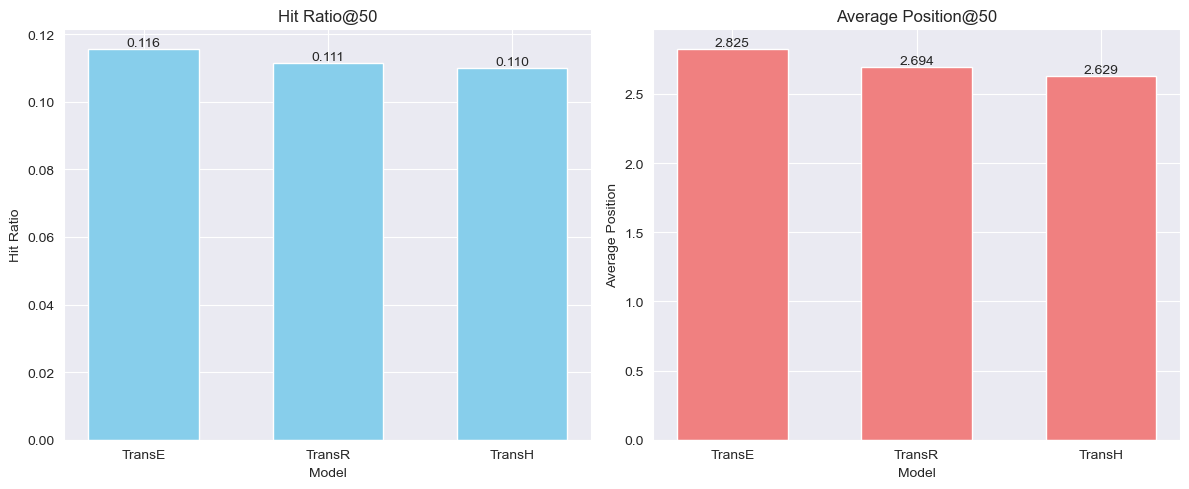

In [27]:
hit_values_3 = [hit_E_3 , hit_R_3, hit_H_3]  
avg_values_3 = [avg_E_3, avg_R_3, avg_H_3]

show_differences(models_2, hit_values_3, avg_values_3)

In [28]:
def compare_differences(models, values_1, values_2, values_3, y_label):  

    x = np.arange(len(models))
    width = 0.6

    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=False)

    bars_1 = axes[0].bar(x, values_1, color='skyblue', width=width)
    axes[0].set_title("Normal")
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel(y_label)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models)

    for bar in bars_1:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    bars_2  = axes[1].bar(x, values_2, color='lightcoral', width=width)
    axes[1].set_title("Most liked")
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel(y_label)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(models)

    for bar in bars_2:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    bars_3  = axes[2].bar(x, values_3, color='lightgreen', width=width)
    axes[2].set_title("K most liked")
    axes[2].set_xlabel('Model')
    axes[2].set_ylabel(y_label)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(models)

    for bar in bars_3:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

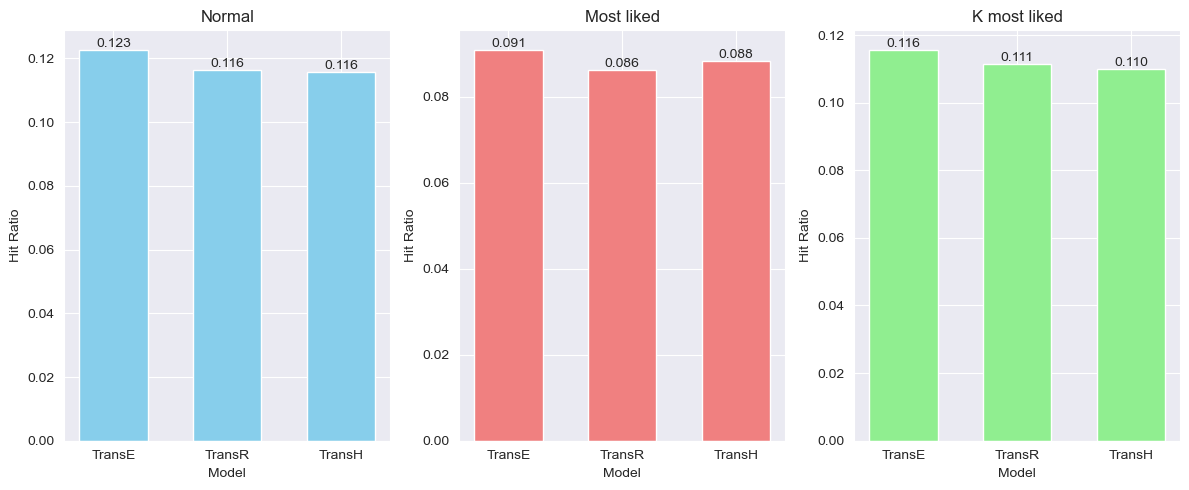

In [29]:
compare_differences(models, hit_values_1, hit_values_2, hit_values_3, "Hit Ratio")

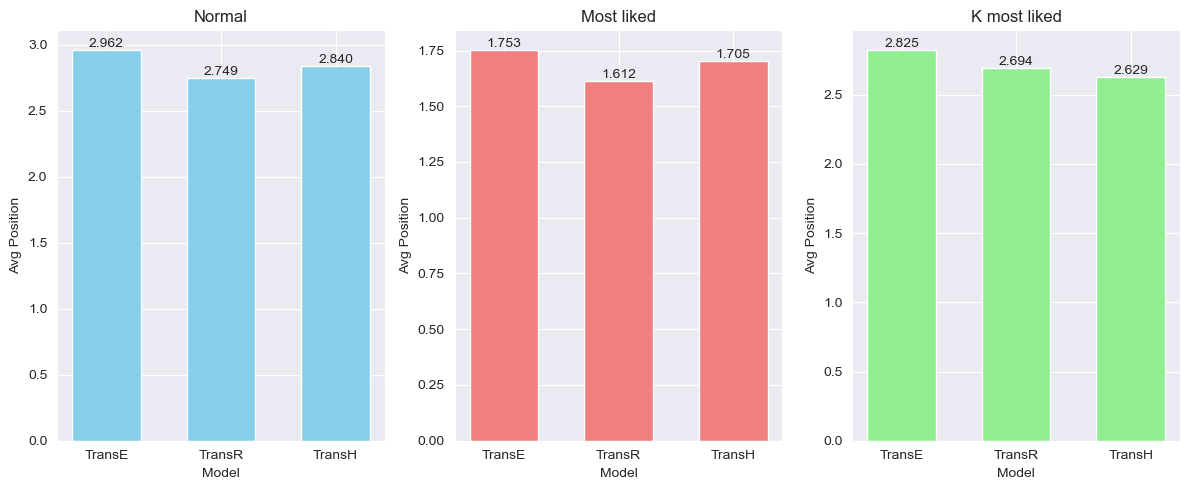

In [30]:
compare_differences(models, avg_values_1, avg_values_2, avg_values_3, "Avg Position")